In [1]:
import numpy as np
from numpy import array
import pandas as pd
from scipy.stats import norm
import random

from sklearn.ensemble import RandomForestRegressor

import xgboost
from xgboost import XGBClassifier

from keras.models import Sequential
from keras.layers import Dense

from util import util

ModuleNotFoundError: No module named 'xgboost'

In [49]:
# We import the sample_submission.csv file as a way of determining
# the order of the rows in out output file
sample_submission = pd.read_csv("../sample_submission.csv")

# The fips_key.csv file contains standard information about each county
key = pd.read_csv("../data/us/processing_data/fips_key.csv", encoding='latin-1')

# Daily deaths contains the death count per day for each county.
# Cumulative deaths contains the total death count for each county
# by day.
daily_deaths = pd.read_csv("../data/us/covid/nyt_us_counties_daily.csv")
cumulative_deaths = pd.read_csv("../data/us/covid/deaths.csv")
county_land_areas = pd.read_csv("../data/us/demographics/county_land_areas.csv", encoding='latin1')
county_populations = pd.read_csv("../data/us/demographics/county_populations.csv", encoding='latin1')
education = pd.read_csv("../data/us/demographics/education.csv", encoding='latin1')
beds = pd.read_csv("../data/us/hospitals/beds_by_county.csv", encoding='latin1')

# List of all counties
all_fips = key["FIPS"].tolist()

# Relevent dates
today = cumulative_deaths.columns[-1]
yesterday = cumulative_deaths.columns[-2]
one_week_ago = cumulative_deaths.columns[-8]
two_weeks_ago = cumulative_deaths.columns[-15]
beginning = cumulative_deaths.columns[4]

# Generate the quantiles for a given value and standard error
# according to a normal distribution.
def generate_quantiles(value, err):
    if err == 0:
        return [value] * 9
    
    quantiles = []
    for quantile in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
        quantiles.append(norm.ppf(quantile, loc=value, scale=err))

    return quantiles

<h1>Some Date Helper Functions</h1>

In [50]:
# Assume date is in format mm/dd/yy, convert to yyyy-mm-dd
def convert_date_to_yyyy_mm_dd(date):
    parts = date.split('/')
    
    # Ensure leading zeros if necessary
    if len(parts[0]) == 1:
        parts[0] = "0" + parts[0]
    
    if len(parts[1]) == 1:
        parts[1] = "0" + parts[1]
        
    return "2020" + "-" + parts[0] + "-" + parts[1]

# Assume date is in format yyyy-mm-dd, convert to mm/dd/yy
def convert_date_to_mm_dd_yy(date):
    parts = date.split('-')
    
    # Remove leading zeros if necessary
    if parts[1][0] == "0":
        parts[1] = parts[1][1:]
    
    if parts[2][0] == "0":
        parts[2] = parts[2][1:]
        
    return parts[1] + "/" + parts[2] + "/" + "20"

In [51]:
util = util(daily_deaths, cumulative_deaths, county_land_areas, county_populations, education, beds, key)

In [61]:
cases_lag_time = 21
cases_window_size = 14

x_train = []
y_train = []
        
for fips in all_fips:
    if util.get_population_per_square_mile(fips) < 2000:
        continue
        
    deaths = list(util.get_deaths_list(fips, convert_date_to_yyyy_mm_dd(two_weeks_ago)))
    cases = list(util.get_cases_list(fips, convert_date_to_yyyy_mm_dd(two_weeks_ago)))
    dates = list(util.get_dates_list(fips, convert_date_to_yyyy_mm_dd(two_weeks_ago)))
    
    for i in range(cases_lag_time, len(dates)):
        x_train.append(util.generate_input_data(fips, dates[i], cases_window_size=cases_window_size, cases_lag_time=cases_lag_time))
        y_train.append(deaths[i])

KeyboardInterrupt: 

In [54]:
rf = RandomForestRegressor(n_jobs=-1, max_depth=4, n_estimators=1000)
rf.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=4, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

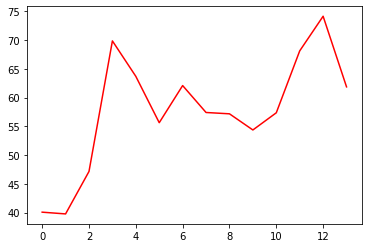

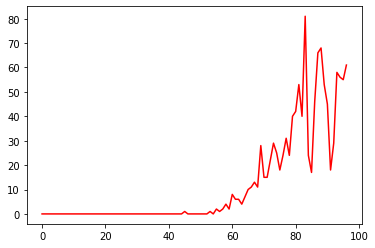

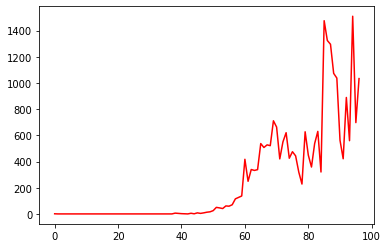

In [59]:
dates = ["2020-04-18", "2020-04-19", "2020-04-20", "2020-04-21", "2020-04-22", "2020-04-23", "2020-04-24",
         "2020-04-25", "2020-04-26", "2020-04-27", "2020-04-28", "2020-04-29", "2020-04-30", "2020-05-01"]
fips = 6037

predictions = []
for date in dates:
    input_data = util.generate_input_data(fips, date, cases_window_size=cases_window_size, cases_lag_time=cases_lag_time)
    input_data = array(input_data)
    predictions += (list(rf.predict([input_data])))

util.plot_list(predictions)
actual_deaths = util.get_deaths_list(fips, endDate=dates[-1])
actual_cases = util.get_cases_list(fips, endDate=dates[-1])
util.plot_list(actual_deaths)
util.plot_list(actual_cases)

In [60]:
prediction_dates = ["2020-04-18", "2020-04-19", "2020-04-20", "2020-04-21", "2020-04-22", "2020-04-23", "2020-04-24",
                    "2020-04-25", "2020-04-26", "2020-04-27", "2020-04-28", "2020-04-29", "2020-04-30", "2020-05-01"]

data = {}
for fips in all_fips:
    print(fips)
    data[fips] = {}
    
    for date in prediction_dates:
        input_data = util.generate_input_data(fips, date, cases_window_size=cases_window_size, cases_lag_time=cases_lag_time)
        prediction = rf.predict([input_data])
        quantiles = generate_quantiles(prediction, prediction * 0.25)
        data[fips][date] = quantiles

1001
1003
1005
1007


KeyboardInterrupt: 

In [15]:
def get_id_list():
    return sample_submission["id"].values

def extract_date_from_id(row_id):
    split = row_id.split('-')
    return '-'.join(split[:-1])

def extract_fips_from_id(row_id):
    return row_id.split('-')[-1]

In [16]:
lists = []
for row_id in get_id_list():
    if random.random() < 0.05:
        print(row_id)
        
    date = extract_date_from_id(row_id)
    fips = int(extract_fips_from_id(row_id))
    
    if not fips in data:
        lst = [row_id] + ["%.2f" % 0.00] * 9
        lists.append(lst)
        continue
    
    if not date in data[fips]:
        lst = [row_id] + ["%.2f" % 0.00] * 9
        lists.append(lst)
        continue
        
    quantiles = data[fips][date]
    quantiles = generate_quantiles(quantiles[4], quantiles[4] * 0.75)
    lst = [row_id]

    for q in quantiles:
        if str(q) == "nan":
            lst.append("%.2f" % 0.00)
        elif q < 0:
            lst.append("%.2f" % 0.00)
        else:
            lst.append("%.2f" % q)
            
    lists.append(lst)

df = pd.DataFrame(lists, columns=sample_submission.columns)

2020-04-01-1021
2020-04-01-1067
2020-04-01-1075
2020-04-01-1091
2020-04-01-1113
2020-04-01-12111
2020-04-01-12125
2020-04-01-13009
2020-04-01-13031
2020-04-01-13051
2020-04-01-13059
2020-04-01-13127
2020-04-01-13151
2020-04-01-13175
2020-04-01-13193
2020-04-01-13309
2020-04-01-13315
2020-04-01-16021
2020-04-01-16059
2020-04-01-17143
2020-04-01-17199
2020-04-01-17201
2020-04-01-18057
2020-04-01-18069
2020-04-01-18093
2020-04-01-18123
2020-04-01-18147
2020-04-01-18149
2020-04-01-18159
2020-04-01-18167
2020-04-01-19043
2020-04-01-19073
2020-04-01-19101
2020-04-01-19163
2020-04-01-19189
2020-04-01-20039
2020-04-01-20061
2020-04-01-20067
2020-04-01-20079
2020-04-01-20109
2020-04-01-20157
2020-04-01-20183
2020-04-01-20195
2020-04-01-21073
2020-04-01-21099
2020-04-01-21165
2020-04-01-21193
2020-04-01-21221
2020-04-01-21225
2020-04-01-2164
2020-04-01-2170
2020-04-01-22013
2020-04-01-2261
2020-04-01-23003
2020-04-01-23021
2020-04-01-26003
2020-04-01-26035
2020-04-01-26049
2020-04-01-26099
2020-

2020-04-10-53067
2020-04-10-54047
2020-04-10-55059
2020-04-10-55063
2020-04-10-55089
2020-04-10-55107
2020-04-10-56023
2020-04-10-72119
2020-04-10-72141
2020-04-10-8023
2020-04-10-8119
2020-04-10-8125
2020-04-11-1029
2020-04-11-1083
2020-04-11-11001
2020-04-11-12033
2020-04-11-12045
2020-04-11-12073
2020-04-11-12085
2020-04-11-12125
2020-04-11-13059
2020-04-11-13103
2020-04-11-13109
2020-04-11-13155
2020-04-11-13211
2020-04-11-13217
2020-04-11-13225
2020-04-11-13229
2020-04-11-13267
2020-04-11-13285
2020-04-11-13301
2020-04-11-13305
2020-04-11-16077
2020-04-11-17001
2020-04-11-17043
2020-04-11-17087
2020-04-11-17093
2020-04-11-17107
2020-04-11-17117
2020-04-11-17189
2020-04-11-18003
2020-04-11-18063
2020-04-11-18097
2020-04-11-18159
2020-04-11-18181
2020-04-11-19007
2020-04-11-19015
2020-04-11-19075
2020-04-11-19077
2020-04-11-19167
2020-04-11-19183
2020-04-11-20037
2020-04-11-20071
2020-04-11-2013
2020-04-11-20197
2020-04-11-21003
2020-04-11-21051
2020-04-11-21057
2020-04-11-21189
202

2020-04-14-22003
2020-04-14-22039
2020-04-14-22047
2020-04-14-22067
2020-04-14-22123
2020-04-14-23019
2020-04-14-23029
2020-04-14-24009
2020-04-14-25001
2020-04-14-26025
2020-04-14-26069
2020-04-14-26133
2020-04-14-28053
2020-04-14-28153
2020-04-14-29025
2020-04-14-29107
2020-04-14-29117
2020-04-14-29123
2020-04-14-29125
2020-04-14-29153
2020-04-14-29175
2020-04-14-29177
2020-04-14-29201
2020-04-14-29225
2020-04-14-30017
2020-04-14-31029
2020-04-14-31113
2020-04-14-31155
2020-04-14-31157
2020-04-14-34041
2020-04-14-35029
2020-04-14-35035
2020-04-14-36029
2020-04-14-36119
2020-04-14-37003
2020-04-14-37009
2020-04-14-37111
2020-04-14-37117
2020-04-14-37169
2020-04-14-37191
2020-04-14-38039
2020-04-14-38043
2020-04-14-38045
2020-04-14-38079
2020-04-14-39003
2020-04-14-39053
2020-04-14-39069
2020-04-14-39131
2020-04-14-40145
2020-04-14-4015
2020-04-14-41041
2020-04-14-41069
2020-04-14-42007
2020-04-14-42043
2020-04-14-42055
2020-04-14-42063
2020-04-14-46019
2020-04-14-46079
2020-04-14-4610

2020-04-18-1095
2020-04-18-1131
2020-04-18-12029
2020-04-18-12045
2020-04-18-12093
2020-04-18-13029
2020-04-18-13069
2020-04-18-13113
2020-04-18-13211
2020-04-18-13215
2020-04-18-13239
2020-04-18-13277
2020-04-18-13289
2020-04-18-13311
2020-04-18-16029
2020-04-18-16065
2020-04-18-17011
2020-04-18-17043
2020-04-18-17093
2020-04-18-17103
2020-04-18-17135
2020-04-18-17183
2020-04-18-17189
2020-04-18-18003
2020-04-18-18057
2020-04-18-18081
2020-04-18-19015
2020-04-18-19025
2020-04-18-19043
2020-04-18-19045
2020-04-18-19153
2020-04-18-20017
2020-04-18-20065
2020-04-18-20075
2020-04-18-20119
2020-04-18-21025
2020-04-18-21033
2020-04-18-21079
2020-04-18-21127
2020-04-18-21131
2020-04-18-21165
2020-04-18-21229
2020-04-18-22057
2020-04-18-22113
2020-04-18-22115
2020-04-18-2261
2020-04-18-23001
2020-04-18-24001
2020-04-18-24009
2020-04-18-24021
2020-04-18-25001
2020-04-18-25013
2020-04-18-25015
2020-04-18-26017
2020-04-18-26023
2020-04-18-27077
2020-04-18-27089
2020-04-18-27131
2020-04-18-27149


2020-04-21-16053
2020-04-21-16059
2020-04-21-16073
2020-04-21-16079
2020-04-21-17045
2020-04-21-17055
2020-04-21-17157
2020-04-21-18057
2020-04-21-18071
2020-04-21-18115
2020-04-21-18127
2020-04-21-18181
2020-04-21-19003
2020-04-21-19007
2020-04-21-19039
2020-04-21-19167
2020-04-21-19173
2020-04-21-19197
2020-04-21-20015
2020-04-21-20043
2020-04-21-20065
2020-04-21-20071
2020-04-21-20183
2020-04-21-20189
2020-04-21-21065
2020-04-21-21069
2020-04-21-21121
2020-04-21-21155
2020-04-21-21179
2020-04-21-21185
2020-04-21-21193
2020-04-21-21199
2020-04-21-22025
2020-04-21-22031
2020-04-21-22043
2020-04-21-22061
2020-04-21-22109
2020-04-21-23005
2020-04-21-24047
2020-04-21-25019
2020-04-21-25023
2020-04-21-26133
2020-04-21-27007
2020-04-21-27069
2020-04-21-27081
2020-04-21-27099
2020-04-21-27105
2020-04-21-27113
2020-04-21-27119
2020-04-21-28003
2020-04-21-28015
2020-04-21-28075
2020-04-21-28077
2020-04-21-28079
2020-04-21-29043
2020-04-21-29077
2020-04-21-29135
2020-04-21-29175
2020-04-21-291

2020-04-24-20111
2020-04-24-20163
2020-04-24-2050
2020-04-24-21033
2020-04-24-21061
2020-04-24-21103
2020-04-24-21181
2020-04-24-2122
2020-04-24-2185
2020-04-24-22005
2020-04-24-2201
2020-04-24-22011
2020-04-24-22071
2020-04-24-24013
2020-04-24-24021
2020-04-24-24029
2020-04-24-26003
2020-04-24-26005
2020-04-24-26009
2020-04-24-26055
2020-04-24-26155
2020-04-24-27001
2020-04-24-27119
2020-04-24-27123
2020-04-24-27127
2020-04-24-28065
2020-04-24-29015
2020-04-24-29019
2020-04-24-29029
2020-04-24-29081
2020-04-24-29117
2020-04-24-29131
2020-04-24-29141
2020-04-24-29159
2020-04-24-29199
2020-04-24-30013
2020-04-24-30037
2020-04-24-30057
2020-04-24-30085
2020-04-24-30093
2020-04-24-31013
2020-04-24-32009
2020-04-24-32023
2020-04-24-32027
2020-04-24-34001
2020-04-24-34027
2020-04-24-35011
2020-04-24-35013
2020-04-24-35021
2020-04-24-36031
2020-04-24-36065
2020-04-24-36097
2020-04-24-36103
2020-04-24-36105
2020-04-24-37011
2020-04-24-37115
2020-04-24-37125
2020-04-24-37183
2020-04-24-38005
2

2020-04-27-19155
2020-04-27-19167
2020-04-27-20055
2020-04-27-20147
2020-04-27-20195
2020-04-27-21143
2020-04-27-21159
2020-04-27-21203
2020-04-27-22045
2020-04-27-22111
2020-04-27-26027
2020-04-27-26075
2020-04-27-26101
2020-04-27-26119
2020-04-27-26123
2020-04-27-27015
2020-04-27-27027
2020-04-27-27031
2020-04-27-27049
2020-04-27-27079
2020-04-27-27121
2020-04-27-27139
2020-04-27-28101
2020-04-27-28119
2020-04-27-28121
2020-04-27-29023
2020-04-27-29031
2020-04-27-29127
2020-04-27-29175
2020-04-27-29195
2020-04-27-29203
2020-04-27-29207
2020-04-27-30071
2020-04-27-30089
2020-04-27-30093
2020-04-27-30095
2020-04-27-31015
2020-04-27-31033
2020-04-27-31073
2020-04-27-31151
2020-04-27-34017
2020-04-27-34027
2020-04-27-34035
2020-04-27-35011
2020-04-27-35039
2020-04-27-35057
2020-04-27-35061
2020-04-27-36019
2020-04-27-36043
2020-04-27-36069
2020-04-27-36089
2020-04-27-36105
2020-04-27-37125
2020-04-27-37143
2020-04-27-37147
2020-04-27-37175
2020-04-27-38001
2020-04-27-38035
2020-04-27-380

2020-04-30-26013
2020-04-30-26069
2020-04-30-26107
2020-04-30-26109
2020-04-30-26135
2020-04-30-27049
2020-04-30-27059
2020-04-30-27061
2020-04-30-27077
2020-04-30-27099
2020-04-30-28037
2020-04-30-28059
2020-04-30-28119
2020-04-30-28149
2020-04-30-29027
2020-04-30-29105
2020-04-30-29229
2020-04-30-30027
2020-04-30-30053
2020-04-30-31039
2020-04-30-31089
2020-04-30-31123
2020-04-30-31137
2020-04-30-31139
2020-04-30-35013
2020-04-30-35039
2020-04-30-36029
2020-04-30-36061
2020-04-30-37091
2020-04-30-37131
2020-04-30-37149
2020-04-30-38027
2020-04-30-39059
2020-04-30-39157
2020-04-30-40029
2020-04-30-40033
2020-04-30-40043
2020-04-30-40055
2020-04-30-40147
2020-04-30-41011
2020-04-30-41043
2020-04-30-41063
2020-04-30-42009
2020-04-30-42073
2020-04-30-42083
2020-04-30-42123
2020-04-30-42127
2020-04-30-42133
2020-04-30-44003
2020-04-30-45025
2020-04-30-45059
2020-04-30-46015
2020-04-30-46061
2020-04-30-46089
2020-04-30-46115
2020-04-30-46119
2020-04-30-46127
2020-04-30-46137
2020-04-30-470

2020-05-04-19007
2020-05-04-19017
2020-05-04-19101
2020-05-04-19157
2020-05-04-19169
2020-05-04-20017
2020-05-04-20043
2020-05-04-20065
2020-05-04-20171
2020-05-04-20201
2020-05-04-21015
2020-05-04-21053
2020-05-04-21181
2020-05-04-21203
2020-05-04-22041
2020-05-04-22081
2020-05-04-22091
2020-05-04-22101
2020-05-04-22125
2020-05-04-23015
2020-05-04-24017
2020-05-04-24021
2020-05-04-24037
2020-05-04-25017
2020-05-04-26015
2020-05-04-26017
2020-05-04-26089
2020-05-04-26091
2020-05-04-26101
2020-05-04-26139
2020-05-04-27019
2020-05-04-27047
2020-05-04-27059
2020-05-04-27135
2020-05-04-27139
2020-05-04-27171
2020-05-04-28017
2020-05-04-28105
2020-05-04-28151
2020-05-04-29009
2020-05-04-29011
2020-05-04-29059
2020-05-04-29101
2020-05-04-29125
2020-05-04-30009
2020-05-04-30053
2020-05-04-30093
2020-05-04-30105
2020-05-04-30111
2020-05-04-31057
2020-05-04-31091
2020-05-04-32009
2020-05-04-32027
2020-05-04-34017
2020-05-04-34021
2020-05-04-34027
2020-05-04-34035
2020-05-04-35031
2020-05-04-360

2020-05-11-18091
2020-05-11-18121
2020-05-11-18129
2020-05-11-19015
2020-05-11-19067
2020-05-11-19107
2020-05-11-19129
2020-05-11-19139
2020-05-11-20005
2020-05-11-20035
2020-05-11-20127
2020-05-11-20129
2020-05-11-20131
2020-05-11-21007
2020-05-11-21013
2020-05-11-21113
2020-05-11-21171
2020-05-11-21189
2020-05-11-21221
2020-05-11-22011
2020-05-11-22017
2020-05-11-22087
2020-05-11-22111
2020-05-11-2261
2020-05-11-25027
2020-05-11-26009
2020-05-11-26109
2020-05-11-26129
2020-05-11-27025
2020-05-11-27083
2020-05-11-27151
2020-05-11-27157
2020-05-11-27161
2020-05-11-28079
2020-05-11-28145
2020-05-11-29013
2020-05-11-29081
2020-05-11-29087
2020-05-11-29101
2020-05-11-29127
2020-05-11-29173
2020-05-11-29181
2020-05-11-29195
2020-05-11-29227
2020-05-11-30003
2020-05-11-30009
2020-05-11-30029
2020-05-11-30069
2020-05-11-30075
2020-05-11-31025
2020-05-11-31071
2020-05-11-31087
2020-05-11-31179
2020-05-11-32021
2020-05-11-33003
2020-05-11-33009
2020-05-11-33019
2020-05-11-35019
2020-05-11-3502

2020-05-14-29021
2020-05-14-29091
2020-05-14-29169
2020-05-14-29203
2020-05-14-30047
2020-05-14-31151
2020-05-14-31181
2020-05-14-34039
2020-05-14-34041
2020-05-14-35039
2020-05-14-35045
2020-05-14-36011
2020-05-14-36017
2020-05-14-36123
2020-05-14-37087
2020-05-14-37109
2020-05-14-37157
2020-05-14-37189
2020-05-14-38039
2020-05-14-38057
2020-05-14-39015
2020-05-14-39043
2020-05-14-39055
2020-05-14-39061
2020-05-14-39071
2020-05-14-39083
2020-05-14-39133
2020-05-14-39167
2020-05-14-42095
2020-05-14-44009
2020-05-14-45007
2020-05-14-45019
2020-05-14-45023
2020-05-14-45043
2020-05-14-45077
2020-05-14-46043
2020-05-14-46071
2020-05-14-47039
2020-05-14-47053
2020-05-14-47069
2020-05-14-47105
2020-05-14-47109
2020-05-14-47171
2020-05-14-48083
2020-05-14-48235
2020-05-14-48303
2020-05-14-48315
2020-05-14-48401
2020-05-14-48477
2020-05-14-49015
2020-05-14-50005
2020-05-14-50019
2020-05-14-5013
2020-05-14-5039
2020-05-14-5061
2020-05-14-5069
2020-05-14-51013
2020-05-14-51033
2020-05-14-51037
2

2020-05-20-34021
2020-05-20-35031
2020-05-20-35035
2020-05-20-35051
2020-05-20-36015
2020-05-20-36071
2020-05-20-36077
2020-05-20-36099
2020-05-20-36103
2020-05-20-37025
2020-05-20-37037
2020-05-20-37127
2020-05-20-37143
2020-05-20-38045
2020-05-20-38079
2020-05-20-38083
2020-05-20-39021
2020-05-20-39077
2020-05-20-39141
2020-05-20-39145
2020-05-20-40025
2020-05-20-4005
2020-05-20-40089
2020-05-20-41047
2020-05-20-42085
2020-05-20-44007
2020-05-20-45005
2020-05-20-45021
2020-05-20-45027
2020-05-20-46011
2020-05-20-46077
2020-05-20-46093
2020-05-20-47049
2020-05-20-47055
2020-05-20-47061
2020-05-20-47131
2020-05-20-47149
2020-05-20-47157
2020-05-20-47187
2020-05-20-48029
2020-05-20-48061
2020-05-20-48067
2020-05-20-48183
2020-05-20-48199
2020-05-20-48203
2020-05-20-48207
2020-05-20-48221
2020-05-20-48305
2020-05-20-48323
2020-05-20-48379
2020-05-20-48381
2020-05-20-48397
2020-05-20-48405
2020-05-20-49001
2020-05-20-49029
2020-05-20-49043
2020-05-20-5009
2020-05-20-5011
2020-05-20-5017
2

2020-05-26-8113
2020-05-27-1023
2020-05-27-1051
2020-05-27-1067
2020-05-27-1071
2020-05-27-12021
2020-05-27-12043
2020-05-27-12069
2020-05-27-12121
2020-05-27-13063
2020-05-27-13071
2020-05-27-13087
2020-05-27-13091
2020-05-27-13121
2020-05-27-13157
2020-05-27-13181
2020-05-27-13191
2020-05-27-13243
2020-05-27-13273
2020-05-27-13289
2020-05-27-16003
2020-05-27-16015
2020-05-27-16069
2020-05-27-16073
2020-05-27-17003
2020-05-27-17015
2020-05-27-17033
2020-05-27-17109
2020-05-27-18001
2020-05-27-18015
2020-05-27-18115
2020-05-27-18137
2020-05-27-19051
2020-05-27-19099
2020-05-27-19163
2020-05-27-19181
2020-05-27-20035
2020-05-27-20053
2020-05-27-20061
2020-05-27-20079
2020-05-27-20105
2020-05-27-20111
2020-05-27-20131
2020-05-27-20185
2020-05-27-2070
2020-05-27-21013
2020-05-27-21061
2020-05-27-21069
2020-05-27-21101
2020-05-27-21181
2020-05-27-21203
2020-05-27-21205
2020-05-27-2180
2020-05-27-22009
2020-05-27-22059
2020-05-27-22073
2020-05-27-22121
2020-05-27-24009
2020-05-27-26035
2020

2020-06-03-19181
2020-06-03-20023
2020-06-03-20083
2020-06-03-20093
2020-06-03-21071
2020-06-03-21141
2020-06-03-22025
2020-06-03-22055
2020-06-03-22127
2020-06-03-26029
2020-06-03-26033
2020-06-03-26065
2020-06-03-26081
2020-06-03-26121
2020-06-03-26165
2020-06-03-27063
2020-06-03-27091
2020-06-03-27143
2020-06-03-28003
2020-06-03-28047
2020-06-03-28135
2020-06-03-28155
2020-06-03-29001
2020-06-03-29053
2020-06-03-29065
2020-06-03-29179
2020-06-03-29201
2020-06-03-29203
2020-06-03-30013
2020-06-03-30055
2020-06-03-30087
2020-06-03-31027
2020-06-03-31075
2020-06-03-31161
2020-06-03-31169
2020-06-03-31173
2020-06-03-33003
2020-06-03-34005
2020-06-03-35013
2020-06-03-35059
2020-06-03-36023
2020-06-03-36071
2020-06-03-36077
2020-06-03-36081
2020-06-03-37013
2020-06-03-37023
2020-06-03-37053
2020-06-03-37063
2020-06-03-37103
2020-06-03-37137
2020-06-03-37175
2020-06-03-37197
2020-06-03-38013
2020-06-03-38015
2020-06-03-38083
2020-06-03-39009
2020-06-03-39017
2020-06-03-39161
2020-06-03-400

2020-06-10-55039
2020-06-10-55133
2020-06-10-6033
2020-06-10-6051
2020-06-10-6093
2020-06-10-6115
2020-06-10-72091
2020-06-10-8069
2020-06-10-8101
2020-06-10-8105
2020-06-10-9001
2020-06-11-1011
2020-06-11-1077
2020-06-11-1099
2020-06-11-12099
2020-06-11-13045
2020-06-11-13059
2020-06-11-13087
2020-06-11-13117
2020-06-11-13125
2020-06-11-13197
2020-06-11-13199
2020-06-11-13245
2020-06-11-13287
2020-06-11-13293
2020-06-11-13315
2020-06-11-16011
2020-06-11-16075
2020-06-11-16087
2020-06-11-17055
2020-06-11-17059
2020-06-11-17061
2020-06-11-17091
2020-06-11-17145
2020-06-11-18043
2020-06-11-18093
2020-06-11-18113
2020-06-11-19017
2020-06-11-19089
2020-06-11-19099
2020-06-11-20003
2020-06-11-20007
2020-06-11-20081
2020-06-11-20187
2020-06-11-20205
2020-06-11-21037
2020-06-11-21051
2020-06-11-21121
2020-06-11-21155
2020-06-11-21173
2020-06-11-21191
2020-06-11-22021
2020-06-11-22041
2020-06-11-22065
2020-06-11-23005
2020-06-11-24021
2020-06-11-26009
2020-06-11-26029
2020-06-11-26039
2020-06-

2020-06-20-18001
2020-06-20-18007
2020-06-20-18033
2020-06-20-18035
2020-06-20-18045
2020-06-20-18053
2020-06-20-18091
2020-06-20-18099
2020-06-20-18117
2020-06-20-19025
2020-06-20-19037
2020-06-20-19045
2020-06-20-19055
2020-06-20-19087
2020-06-20-19167
2020-06-20-20001
2020-06-20-20027
2020-06-20-20037
2020-06-20-20039
2020-06-20-20105
2020-06-20-20201
2020-06-20-21023
2020-06-20-21037
2020-06-20-21063
2020-06-20-21195
2020-06-20-22023
2020-06-20-22027
2020-06-20-22029
2020-06-20-22043
2020-06-20-22063
2020-06-20-22123
2020-06-20-2282
2020-06-20-24029
2020-06-20-25001
2020-06-20-26043
2020-06-20-26075
2020-06-20-26087
2020-06-20-26117
2020-06-20-26127
2020-06-20-26165
2020-06-20-27005
2020-06-20-27045
2020-06-20-28025
2020-06-20-28077
2020-06-20-28151
2020-06-20-29045
2020-06-20-29047
2020-06-20-29061
2020-06-20-29151
2020-06-20-29186
2020-06-20-30029
2020-06-20-30083
2020-06-20-30109
2020-06-20-31005
2020-06-20-31013
2020-06-20-31043
2020-06-20-31121
2020-06-20-31137
2020-06-20-3401

2020-06-26-39011
2020-06-26-39089
2020-06-26-39159
2020-06-26-39165
2020-06-26-40033
2020-06-26-4005
2020-06-26-40085
2020-06-26-41055
2020-06-26-42001
2020-06-26-44005
2020-06-26-45001
2020-06-26-45037
2020-06-26-45075
2020-06-26-46017
2020-06-26-46039
2020-06-26-46079
2020-06-26-47045
2020-06-26-47059
2020-06-26-47065
2020-06-26-47079
2020-06-26-48025
2020-06-26-48069
2020-06-26-48153
2020-06-26-48215
2020-06-26-48227
2020-06-26-48233
2020-06-26-48285
2020-06-26-48307
2020-06-26-48381
2020-06-26-48437
2020-06-26-48469
2020-06-26-48493
2020-06-26-50003
2020-06-26-50019
2020-06-26-5029
2020-06-26-51005
2020-06-26-51049
2020-06-26-51069
2020-06-26-51101
2020-06-26-51153
2020-06-26-51165
2020-06-26-5139
2020-06-26-51520
2020-06-26-51760
2020-06-26-53031
2020-06-26-53045
2020-06-26-53053
2020-06-26-55035
2020-06-26-55071
2020-06-26-6061
2020-06-26-72051
2020-06-26-72101
2020-06-26-78030
2020-06-26-8013
2020-06-26-8027
2020-06-26-8075
2020-06-26-8077
2020-06-26-8125
2020-06-27-1017
2020-06

In [17]:
df.to_csv("rf_submission.csv", index=False, sep=',')

In [ ]:
print(util.get_education_data(2201))